In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from cmocean import cm as cmo
plt.style.use('seaborn-paper')
#plt.style.use('ggplot')

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import glob
import matplotlib.dates as mdates
import datetime
import dask.array as da

In [2]:
pathdat = "../data/track_data/csvs/Isaias_2020.csv"
df = pd.read_csv(pathdat)
hurrlats, hurrlons = df['LAT'].values, df['LON'].values

In [3]:
hurrtnum = np.ones_like(hurrlats)
for i in range(len(hurrlats)):
    hdate = datetime.datetime.strptime(df['DATE'][i]+" "+df['ISO_TIME_________'][i], "%m/%d/%y %H:%M:%S")
    hurrtnum[i] = mdates.date2num(hdate)

In [4]:
dataloc = "http://gliders.ioos.us/thredds/dodsC/deployments/rutgers/ng619-20200722T1900/ng619-20200722T1900.nc3.nc?trajectory[0:1:0],wmo_id[0:1:0],time[0:1:0][0:1:8604],latitude[0:1:0][0:1:8604],longitude[0:1:0][0:1:8604],time_uv[0:1:0][0:1:8604],lat_uv[0:1:0][0:1:8604],lon_uv[0:1:0][0:1:8604],precise_time[0:1:0][0:1:8604][0:1:268],depth[0:1:0][0:1:8604][0:1:268],pressure[0:1:0][0:1:8604][0:1:268],temperature[0:1:0][0:1:8604][0:1:268],conductivity[0:1:0][0:1:8604][0:1:268],salinity[0:1:0][0:1:8604][0:1:268],density[0:1:0][0:1:8604][0:1:268]"
df      = xr.open_dataset(dataloc, decode_times=False)

In [5]:
dataAS  = "../data/AtlanticShores_833d_ebdb_69d0_d81b_55e4_f5f5.nc"
dataASwinds = "../data/AtlanticShores_Isaias_Winds.nc"
dAS     = xr.open_dataset(dataAS)
dAw     = xr.open_dataset(dataASwinds)

In [6]:
dAS.time[0].values, dAS.time[-1].values, 

(numpy.datetime64('2020-07-21T00:00:00.000000000'),
 numpy.datetime64('2020-09-22T21:00:00.000000000'))

In [7]:
dAw.altitude

<xarray.DataArray 'altitude' (row: 62326)>
array([ 10.,  40.,  60., ..., 180., 200., 250.])
Dimensions without coordinates: row
Attributes:
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  up
    actual_range:            [ 10. 250.]
    axis:                    Z
    colorBarMaximum:         8000.0
    colorBarMinimum:         -8000.0
    colorBarPalette:         TopographyDepth
    ioos_category:           Location
    long_name:               Altitude
    positive:                up
    source_name:             height
    standard_name:           altitude
    units:                   m

In [8]:
start = mdates.date2num(datetime.datetime(2020,8,4,0))
enddd = mdates.date2num(datetime.datetime(2020,8,5,18))
myFmt = mdates.DateFormatter('%m/%d\n%H:%M')

In [9]:
vellen = len(dAS.sea_water_speed[::34].values)

cross_shelf_u = np.ones((34,vellen))
u_angle       = np.ones((34,vellen))
along_shelf_v = np.ones((34,vellen))
coast_angle   = 0

for i in range(34):
    cross_shelf_u[i,:] = dAS.sea_water_speed[i::34].values*np.cos(np.deg2rad(dAS.sea_water_velocity_to_direction[i::34].values + coast_angle))
    u_angle[i,:]       = np.mod(np.deg2rad(dAS.sea_water_velocity_to_direction[i::34].values + coast_angle),2*np.pi)
    along_shelf_v[i,:] = dAS.sea_water_speed[i::34].values*np.sin(np.deg2rad(dAS.sea_water_velocity_to_direction[i::34].values + coast_angle))
    
depths = -1*(np.arange(34)+3)
times  = mdates.date2num(dAS.time[::34])

In [10]:
depths

array([ -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12, -13, -14, -15,
       -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28,
       -29, -30, -31, -32, -33, -34, -35, -36])

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


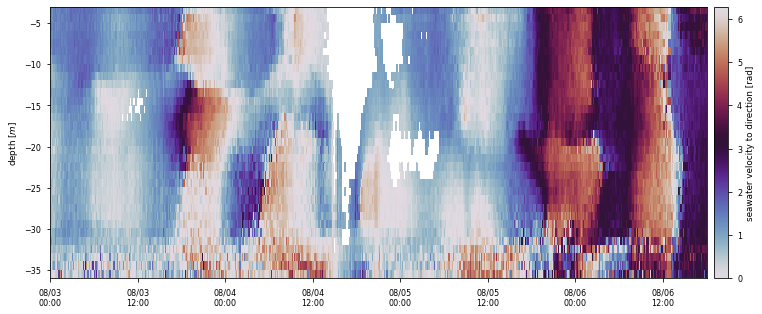

In [11]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, u_angle, vmin=0, vmax=2*np.pi, cmap='twilight')
plt.colorbar(pad=0.01, label="seawater velocity to direction [rad]")
plt.xlim([start-1, enddd+1])
plt.ylabel('depth [$m$]')
plt.gca().xaxis.set_major_formatter(myFmt)
# save the plot as a file
plt.savefig('Isaias_AtlanticShores_theta.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


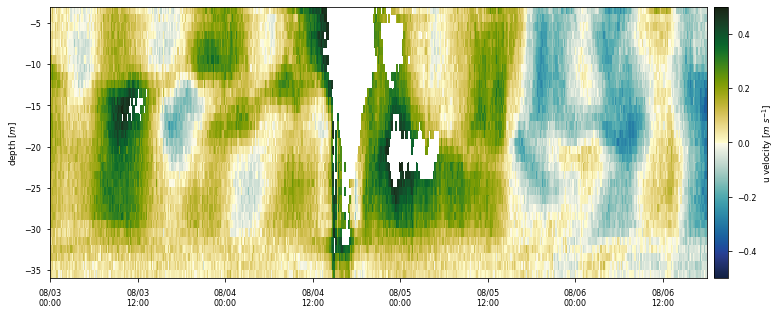

In [12]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, cross_shelf_u/100, vmax=0.5, vmin=-0.5, cmap='cmo.delta')
plt.colorbar(pad=0.01, label="u velocity [$m$ $s^{-1}$]")
plt.xlim([start-1, enddd+1])
plt.ylabel('depth [$m$]')
plt.gca().xaxis.set_major_formatter(myFmt)
# save the plot as a file
#plt.savefig('Isaias_AtlanticShores_u.png', bbox_inches='tight', dpi=200)
plt.show()

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


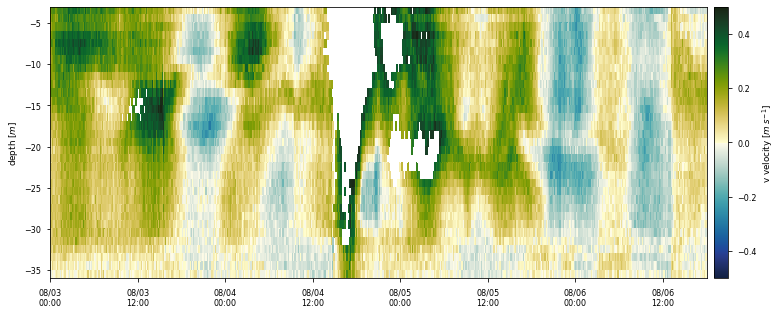

In [13]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, along_shelf_v/100, vmax=0.5, vmin=-0.5, cmap='cmo.delta')
plt.colorbar(pad=0.01, label="v velocity [$m$ $s^{-1}$]")
plt.xlim([start-1, enddd+1])
plt.ylabel('depth [$m$]')
plt.gca().xaxis.set_major_formatter(myFmt)
# save the plot as a file
plt.savefig('Isaias_AtlanticShores_v.png', bbox_inches='tight', dpi=200)
plt.show()

In [14]:
dudz = np.gradient(cross_shelf_u,axis=0)/100
dvdz = np.gradient(along_shelf_v,axis=0)/100
S2   = dudz**2 + dvdz**2

In [15]:
wind_dnum = mdates.date2num(dAw.time)
wind_sped = dAw.wind_speed.values
wind_dfro = dAw.wind_from_direction.values

gw = np.where(wind_sped < 50)
wind_dnum = wind_dnum[gw]
wind_sped = wind_sped[gw]
wind_dfro = wind_dfro[gw]

gw = np.where(wind_dfro > 1)
wind_dnum = wind_dnum[gw]
wind_sped = wind_sped[gw]
wind_dfro = wind_dfro[gw]

In [16]:
dAw.wind_from_direction

<xarray.DataArray 'wind_from_direction' (row: 62326)>
array([2.333809e+02, 6.055000e-02, 2.282549e+02, ..., 3.717969e+01,
       3.541211e+01, 3.717969e+01])
Dimensions without coordinates: row
Attributes:
    actual_range:           [ -1.      360.82324]
    colorBarMaximum:        360.0
    colorBarMinimum:        0.0
    coverage_content_type:  physicalMeasurement
    ioos_category:          Wind
    long_name:              Wind From Direction
    standard_name:          wind_from_direction
    units:                  degree

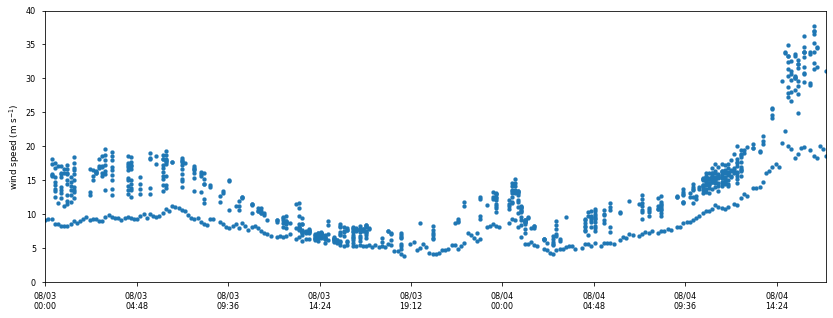

In [17]:
plt.figure(figsize=(14,5))
plt.scatter(wind_dnum, wind_sped, s=16)
plt.ylabel('wind speed (m s$^{-1}$)')
plt.xlim([start-1, enddd-1-1/24])
plt.ylim([0,40])
#plt.grid(c='k', linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(myFmt)

plt.show()

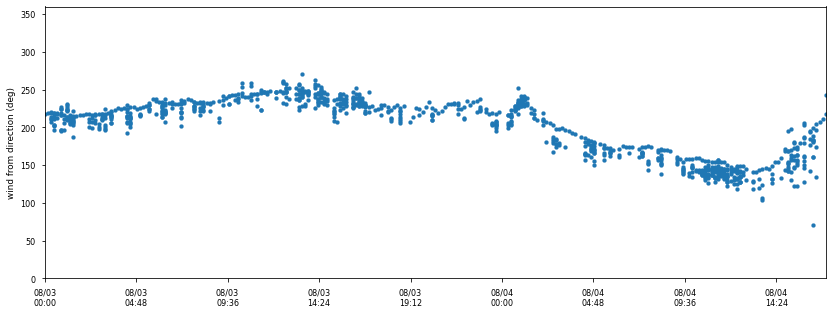

In [18]:
plt.figure(figsize=(14,5))
plt.scatter(wind_dnum, wind_dfro, s=16)
plt.ylabel('wind from direction (deg)')
plt.xlim([start-1, enddd-1-1/24])
plt.ylim([0,360])
#plt.grid(c='k', linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(myFmt)

plt.show()

In [19]:
ga = wind_dnum < enddd-1-1/24
gb = wind_dnum > start-1
gw = np.logical_and(ga,gb)
AL_dnum = wind_dnum[gw]
AL_sped = wind_sped[gw]
AL_dfro = wind_dfro[gw]

angle_of_coast = 210
dt_AL   = np.gradient(AL_dnum*86400)

$\tau^s = \rho_{air} C_D (U_w - U)^2 $

$ \Delta X = \int^t dt \frac{\tau^s(t)}{\rho_o f \delta_E} $

In [20]:
CD     = 2e-3  # 
rhoair = 1.225 # kg/m³
rhowat = 1022  # kg/m³
deltaE = 10    # m
DeltaX = 0     # m
f      = 1e-4  # 1/s
for i, dt in enumerate(dt_AL):
    tau_s   = rhoair*CD*AL_sped[i]**2
    DeltaX += dt * tau_s / (rhowat * deltaE * f)

In [21]:
DeltaX/1000

48.13393764671447

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


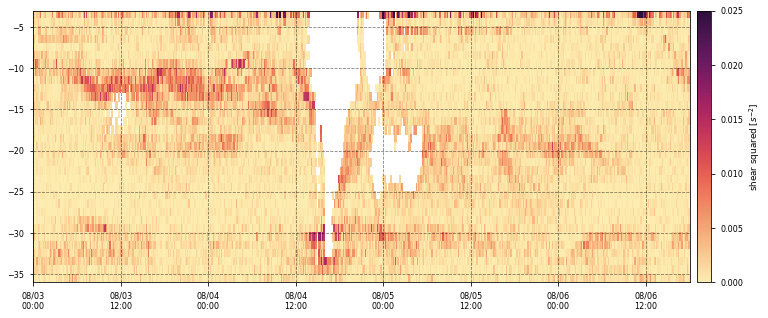

In [22]:
plt.figure(figsize=(14,5))
plt.pcolor(times, depths, S2, vmax=0.025, vmin=0, cmap='cmo.matter')
plt.colorbar(pad=0.01, label="shear squared [$s^{-2}$]")
plt.xlim([start-1, enddd+1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid(c='k', linestyle='--', alpha=0.5)
# save the plot as a file
plt.savefig('Isaias_AtlanticShores_S2.png', bbox_inches='tight', dpi=200)
plt.show()

In [23]:
time_origin = datetime.datetime(1970,1,1)
datenum = np.ones_like(df.depth.values)
dlen    = np.shape(df.depth)[2]
for i, sec in enumerate(df.time.values[0,:]):
    datetmp   = time_origin + datetime.timedelta(seconds = sec)
    datenum[0,i,:] = mdates.date2num(datetmp)*np.ones(dlen)

In [24]:
dP = np.gradient(df.depth[0,:,:].values, axis=(1))
dt = np.gradient(datenum, axis=(1)) / 96400
dPdt = dP/dt

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
glats = np.squeeze(df.latitude.values)
glons = np.squeeze(df.longitude.values)

distance_metric = np.ones((np.size(glats),np.size(hurrlats)))
for i, glatitude in enumerate(glats):
    for j, hlatitude in enumerate(hurrlats):
        latdist = glatitude - hlatitude
        londist = glons[i] - hurrlons[j]
        distance_metric[i,j] = np.sqrt(latdist**2 + londist**2)

b = np.amin(distance_metric)
ktime = np.where(distance_metric == b)[1][0]
eyepassage = hurrtnum[ktime]

In [26]:
start = eyepassage - 4
enddd = eyepassage + 2

In [27]:
### binning
x = datenum[0,:,:].reshape(np.size(datenum[0,:,:]))
y = -df.depth[0,:,:].values.reshape(np.size(datenum[0,:,:]))
t = df.temperature[0,:,:].values.reshape(np.size(datenum[0,:,:]))
s = df.salinity[0,:,:].values.reshape(np.size(datenum[0,:,:]))
timepoints = int((enddd - start)*24)+1 #
tgrid = np.linspace(start,enddd,timepoints)
zgrid = np.linspace(-93,-3,46)
T, Z = np.meshgrid(tgrid,zgrid)

In [28]:
TEMPS = np.ones_like(T)
SALT = np.ones_like(T)
np.shape(TEMPS)

(46, 145)

In [29]:
for i in range(len(tgrid)-1):
    Tmore = x > tgrid[i]
    Tless = x < tgrid[i+1]
    qT = np.logical_and(Tmore,Tless)
    for j in range(len(zgrid)-1):
        Zmore = y > zgrid[j]
        Zless = y < zgrid[j+1]
        qZ = np.logical_and(Zmore,Zless)
        qALL = np.logical_and(qZ,qT)
        xZ = x[qALL]
        yZ = y[qALL]
        tZ = t[qALL]
        sZ = s[qALL]
        if len(tZ) > 0:
            TEMPS[j,i] = np.nanmedian(tZ)
            SALT[j,i] = np.nanmedian(sZ)
        else:
            TEMPS[j,i] = np.nan
            SALT[j,i] = np.nan

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


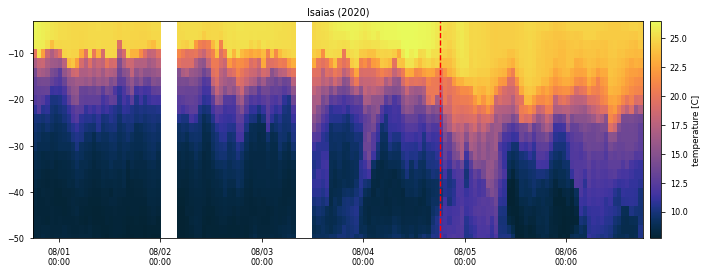

In [30]:
plt.figure(figsize=(13,4))
plt.pcolor(T, Z, TEMPS, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([-50,-3])
plt.axvline(x = eyepassage, c='r', linestyle="--")

#plt.scatter(ndb_datenum, -(windspeed), c=winddir, s=36, vmin=0, vmax=360, cmap=cmo.phase)
plt.title('Isaias (2020)')
plt.savefig("FIGS/temperatures_Isaias2020.pdf", bbox_inches='tight')
plt.show()

In [31]:
df.depth.values.shape

(1, 8605, 269)

In [32]:
df.temperature.shape

(1, 8605, 269)

In [33]:
bef = tgrid < eyepassage-0.5
aft = tgrid > eyepassage-2.5
qb   = np.logical_and(bef,aft)
temps_bef = TEMPS[:3,qb]
mean_Tbef = np.nanmean(temps_bef)

bef = tgrid < eyepassage+(1/24)
aft = tgrid > eyepassage-(1/24)
qeye  = np.logical_and(bef,aft)
temps_eye = TEMPS[:3,qeye]
mean_Teye = np.nanmean(temps_eye)

bef = tgrid < eyepassage+0.5
aft = tgrid > eyepassage+0.25
qa   = np.logical_and(bef,aft)
temps_aft = TEMPS[:3,qa]
mean_Taft = np.nanmean(temps_aft)

Ahead_of_eye_cooling = mean_Tbef - mean_Teye
After_of_eye_cooling = mean_Teye - mean_Taft

print(Ahead_of_eye_cooling, After_of_eye_cooling)

-0.0051022832707836585 -0.5468379974365245


In [34]:
dense0 = 1022.8
T0     = 17
S0     = 31.5
alpha  = 0.000281
beta   = 0.000766
g      = 9.81

dense = dense0 * (1 + alpha*(TEMPS-T0) + beta*(SALT-S0))
buoy  = -g * dense / dense0

dz = np.gradient(Z, axis=[0])
db = np.gradient(buoy, axis=[1])
dbdz = -db / dz

dbdz_b = dbdz[:,qb]
dbdz_b.shape
maxN2 = np.ones(dbdz_b.shape[1]-1)
for i in range(dbdz_b.shape[1]-1):
    prof = dbdz_b[i,:]
    maxN2[i] = np.nanmax(prof)
    
print("N2max =",np.nanmean(maxN2))

N2max = 0.002069113490300821


/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(0.5, 1.0, 'Isaias (2020)')

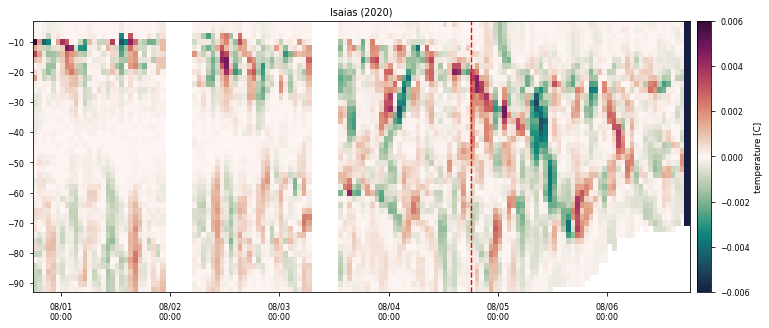

In [35]:
plt.figure(figsize=(14,5))
plt.pcolor(T, Z, dbdz, cmap=cmo.curl, vmin=-0.006, vmax=0.006 )
plt.colorbar(pad=0.01, label="temperature [C]")
plt.xlim([start, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.axvline(x = eyepassage, c='r', linestyle="--")

#plt.scatter(ndb_datenum, -(windspeed), c=winddir, s=36, vmin=0, vmax=360, cmap=cmo.phase)
plt.title('Isaias (2020)')

In [36]:
def pycnocline_width(profile_tmp, d, low=10.5, high=11.5):
    finite = np.where(np.isfinite(profile_tmp))[0]
    d=np.abs(d)
    maxdepth = d[np.min(finite)]
    mindepth = d[np.max(finite)]
    try:
        new_d = np.arange(mindepth,maxdepth,0.1)
        y = interp.interp1d(d[finite],profile_tmp[finite], kind='linear')
        new_tmp = y(new_d)
        tmp_low = np.abs(new_tmp - low)
        tmp_high = np.abs(new_tmp - high)
        q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
        q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
        #delta_d = new_d[q_high] - new_d[q_low]
        return new_d[q_high], new_d[q_low]
    except:
        return np.nan, np.nan

import scipy.interpolate as interp

low_depth  = np.ones_like(tgrid)
high_depth = np.ones_like(tgrid)

d = zgrid

for I in range(len(tgrid)):
    profile_tmp = TEMPS[:,I]
    a, b = pycnocline_width(profile_tmp, d, low=16, high=19)
    if np.abs(a-b) < 0.25:
        low_depth[I], high_depth[I] = np.nan, np.nan
    else:
        low_depth[I], high_depth[I] = a, b

In [37]:
Pw_bef = np.nanmedian(low_depth[qb]-high_depth[qb])
Pw_eye = np.nanmedian(low_depth[qeye]-high_depth[qeye])
Pw_aft = np.nanmedian(low_depth[qa]-high_depth[qa])

Pw_bef, Pw_eye, Pw_aft, np.nanmean(high_depth[qb])-np.nanmean(high_depth[qeye])

(-3.100000000000005,
 -3.9000000000000057,
 -6.200000000000003,
 -4.276744186046518)

In [38]:
st = mdates.date2num(datetime.datetime(2020,8,2,12))
en = mdates.date2num(datetime.datetime(2020,8,3,18))

a = tgrid < en
b = tgrid > st
q = np.logical_and(a,b)
temps_before = TEMPS[:,q]
temps_before = np.nanmean(temps_before, axis=(1))

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


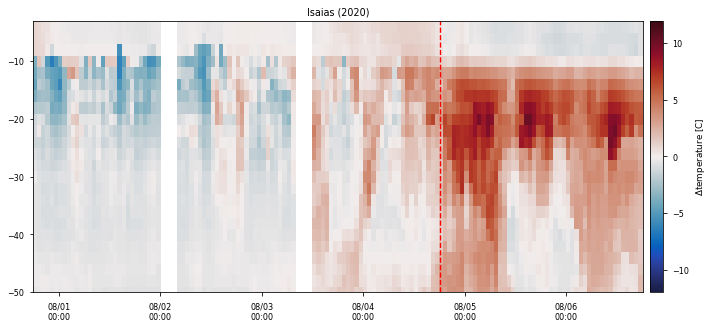

In [39]:
plt.figure(figsize=(13,5))
plt.pcolor(T, Z, TEMPS - temps_before[:,np.newaxis], cmap=cmo.balance, vmax =12, vmin=-12)
plt.colorbar(pad=0.01, label="$\Delta$temperature [C]")
#plt.xlim([start+1.5, enddd])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([-50,-3])
plt.axvline(x = eyepassage, c='r', linestyle="--")
#plt.scatter(ndb_datenum, -(windspeed), c=winddir, s=36, vmin=0, vmax=360, cmap=cmo.phase)
plt.title('Isaias (2020)')
plt.savefig("FIGS/dT_Isaias2020.pdf", bbox_inches='tight')
plt.show()

In [40]:
winddata = "../data/ndbc_years/4406582020.txt"
winddat2 = "../data/ndbc_years/4400982020.txt"

ndb = pd.read_csv(winddata, skiprows=[1], delim_whitespace=True)
nd2 = pd.read_csv(winddat2, skiprows=[1], delim_whitespace=True)

In [41]:
list(ndb)

['#YY',
 'MM',
 'DD',
 'hh',
 'mm',
 'WDIR',
 'WSPD',
 'GST',
 'WVHT',
 'DPD',
 'APD',
 'MWD',
 'PRES',
 'ATMP',
 'WTMP',
 'DEWP',
 'VIS',
 'TIDE']

In [42]:
ndb_datenum = [mdates.date2num(datetime.datetime(ndb['#YY'][i],ndb['MM'][i],ndb['DD'][i],ndb['hh'][i],ndb['mm'][i])) 
               for i in range(len(ndb))]
ndb_datenum = np.asarray(ndb_datenum)

nd2_datenum = [mdates.date2num(datetime.datetime(nd2['#YY'][i],nd2['MM'][i],nd2['DD'][i],nd2['hh'][i],nd2['mm'][i])) 
               for i in range(len(nd2))]
nd2_datenum = np.asarray(nd2_datenum)

In [43]:
def cooling_defs_1D(datenums,eyepassage,wtemp):
    bef = datenums < eyepassage-0.5
    aft = datenums > eyepassage-2.0
    qb   = np.logical_and(bef,aft)
    temps_bef = wtemp[qb]
    mean_Tbef = np.nanmean(temps_bef)

    bef = datenums < eyepassage+(1/24)
    aft = datenums > eyepassage-(1/24)
    qeye  = np.logical_and(bef,aft)
    temps_eye = wtemp[qeye]
    mean_Teye = np.nanmean(temps_eye)

    bef = datenums < eyepassage+0.5
    aft = datenums > eyepassage+0.25
    qa   = np.logical_and(bef,aft)
    temps_aft = wtemp[qa]
    mean_Taft = np.nanmean(temps_aft)

    Ahead_of_eye_cooling = mean_Tbef - mean_Teye
    After_of_eye_cooling = mean_Teye - mean_Taft

    return(Ahead_of_eye_cooling, After_of_eye_cooling)

In [44]:
cooling_defs_1D(ndb_datenum,eyepassage,ndb['WTMP'].values)

(7.833784355179702, 0.524155844155846)

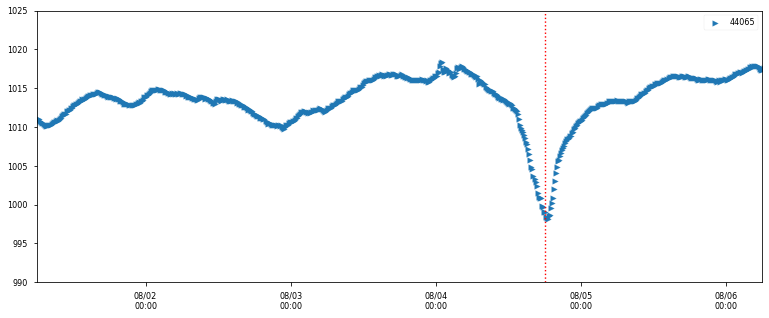

In [45]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum, ndb['PRES'], marker=">", label="44065")
#plt.scatter(nd2_datenum, nd2['PRES'], c=nd2['WTMP'], vmin=15, vmax=27, cmap=cmo.thermal, marker="+", label="44009")
plt.xlim([start+0.5, enddd-0.5])
plt.legend()
plt.axvline(x = eyepassage, c='r', linestyle=":")
plt.ylim([990,1025])
plt.gca().xaxis.set_major_formatter(myFmt)

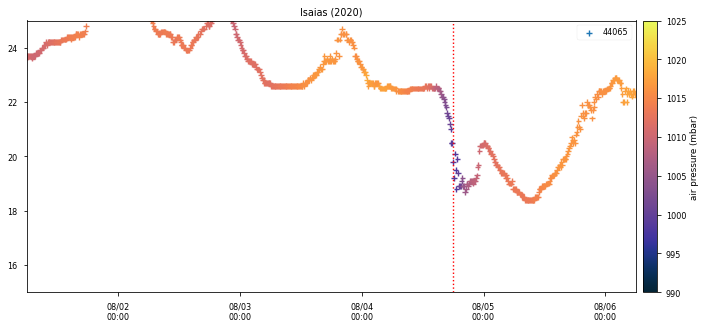

In [46]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum, ndb['WTMP'], c=ndb['PRES'], vmin=990, vmax=1025, cmap=cmo.thermal, marker="+", label="44065")
#plt.scatter(nd2_datenum, nd2['PRES'], c=nd2['WTMP'], vmin=15, vmax=27, cmap=cmo.thermal, marker="+", label="44009")
plt.colorbar(pad=0.01,label='air pressure (mbar)')
plt.xlim([start+0.5, enddd-0.5])
plt.legend()
plt.axvline(x = eyepassage, c='r', linestyle=":")
plt.ylim([15,25])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.title('Isaias (2020)')
plt.savefig("FIGS/wTnP_Isaias2020.pdf", bbox_inches='tight')

In [47]:
windspeed = np.ones_like(ndb['WSPD'][:])
winddir   = np.ones_like(ndb['WSPD'][:])
wtemp     = np.ones_like(ndb['WSPD'][:])
airpress  = np.ones_like(ndb['WSPD'][:])

for i, wspd in enumerate(ndb['WSPD'][:]):
    try:
        windspeed[i] = np.float(wspd)
        winddir[i]   = np.float(ndb['WDIR'][i])
        wtemp[i]     = np.float(ndb['WTMP'][i])
        airpress[i]  = np.float(ndb['PRES'][i])
    except:
        windspeed[i] = np.nan
        winddir[i]   = np.nan
        wtemp[i]     = np.nan
        airpress[i]  = np.nan

windspee2 = np.ones_like(nd2['WSPD'][:])
winddi2   = np.ones_like(nd2['WSPD'][:])
wtem2     = np.ones_like(nd2['WSPD'][:])
airpres2  = np.ones_like(nd2['WSPD'][:])

for i, wspd in enumerate(nd2['WSPD'][:]):
    try:
        windspee2[i] = np.float(wspd)
        winddi2[i]   = np.float(nd2['WDIR'][i])
        wtem2[i]     = np.float(nd2['WTMP'][i])
        airpres2[i]  = np.float(nd2['PRES'][i])
    except:
        windspee2[i] = np.nan
        winddi2[i]   = np.nan
        wtem2[i]     = np.nan
        airpres2[i]  = np.nan

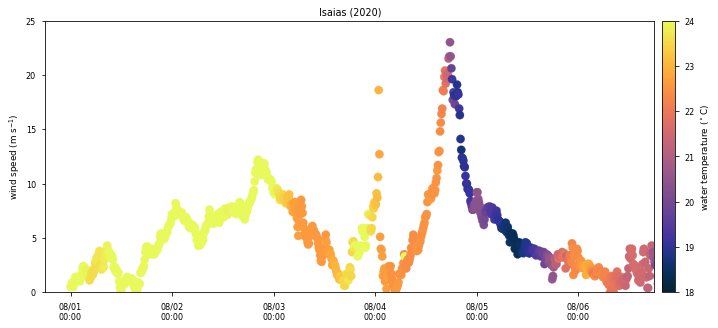

In [48]:
plt.figure(figsize=(13,5))
plt.scatter(ndb_datenum, windspeed, c=wtemp, cmap=cmo.thermal, s=70, vmin=18, vmax=24)
plt.colorbar(pad=0.01, label='water temperature ($^\circ$C)')
plt.ylabel('wind speed (m s$^{-1}$)')
plt.ylim([0, 25])
plt.xlim([start, enddd])
plt.title('Isaias (2020)')
plt.gca().xaxis.set_major_formatter(myFmt)

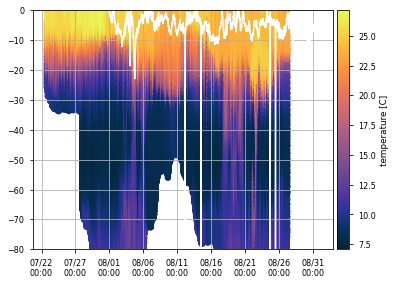

In [49]:
plt.scatter(datenum[0,:,:], -df.depth[0,:,:], c=df.temperature[0,:,:], s=36, cmap=cmo.thermal)
plt.colorbar(pad=0.01, label="temperature [C]")
plt.plot(ndb_datenum, -1*(windspeed), c='w')
#plt.xlim([mdates.date2num(datetime.datetime(2020,8,4,12)), mdates.date2num(datetime.datetime(2020,8,4,18))])
plt.ylim([-80,0])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.grid()
plt.show()

In [50]:
depthlines = np.arange(50)+5
casttimes = datenum[0,:,0]
np.shape(casttimes)

DLINES, CTIMES = np.meshgrid(depthlines, casttimes)

In [51]:
np.shape(DLINES)

(8605, 50)

In [52]:
TLINES = np.ones_like(DLINES) * np.nan

for i, tnum in enumerate(casttimes[:]):
    d = df.depth[0,i,:].values
    temps = df.temperature[0,i,:].values
    maxD = np.nanmax(d)
    tgood = temps[np.isfinite(temps)]
    dgood = d[np.isfinite(temps)]
    sortq = np.argsort(dgood)
    tgood = tgood[sortq]
    dgood = dgood[sortq]
    q = np.where(depthlines < maxD)
    xx = depthlines[q]
    TLINES[i,:len(xx)] = np.interp(xx,dgood,tgood)
    #plt.plot(xx, np.interp(xx,dgood,tgood))

In [53]:
import scipy.interpolate as interp

def pycnocline_width(profile_tmp, d, low=10.5, high=11.5):
    finite = np.where(np.isfinite(profile_tmp))[0]
    maxdepth = d[np.min(finite)]
    mindepth = d[np.max(finite)]
    new_d = np.arange(mindepth,maxdepth,0.1)
    y = interp.interp1d(d[finite],profile_tmp[finite], kind='linear')
    new_tmp = y(new_d)
    tmp_low = np.abs(new_tmp - low)
    tmp_high = np.abs(new_tmp - high)
    q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
    q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
    #delta_d = new_d[q_high] - new_d[q_low]
    return new_d[q_high], new_d[q_low]

np.shape(TLINES)

(8605, 50)

In [54]:
low_depth  = np.ones_like(casttimes)
high_depth = np.ones_like(casttimes)

for I in range(len(casttimes)):
    new_tmp = TLINES[I,:]
    if sum(np.isfinite(new_tmp)) > 3:
        tmp_low = np.abs(new_tmp - 16)
        tmp_high = np.abs(new_tmp - 22)
        q_low = np.where(tmp_low == np.nanmin(tmp_low))[0][0]
        q_high = np.where(tmp_high == np.nanmin(tmp_high))[0][0]
        a, b = depthlines[q_high], depthlines[q_low]
        if np.abs(a-b) < 0.25:
            low_depth[I], high_depth[I] = np.nan, np.nan
        else:
            low_depth[I], high_depth[I] = a, b
    else: low_depth[I], high_depth[I] = np.nan, np.nan

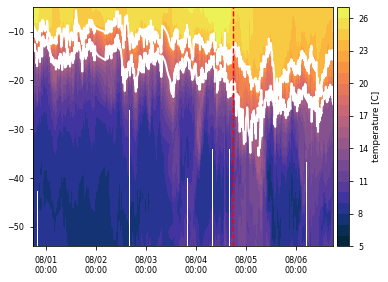

In [55]:
plt.contourf(CTIMES, -DLINES, TLINES, cmap='cmo.thermal', levels=np.arange(23)+5)
plt.xlim([start, enddd])
plt.colorbar(pad=0.01, label="temperature [C]")
plt.contour(CTIMES, -DLINES, TLINES, levels=np.array([16,22]), colors='w', linewidths=2)
plt.axvline(x = eyepassage, c='r', linestyle="--")
#plt.plot(ndb_datenum, 1*(windspeed), c='r')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.savefig('Isaias_2020_wind.pdf', bbox_inches='tight')

Text(0, 0.5, 'pycnocline width [m]')

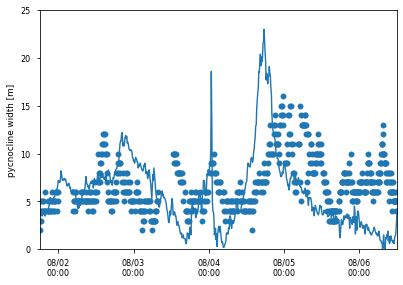

In [56]:
plt.scatter(casttimes, high_depth - low_depth)
plt.plot(ndb_datenum, (windspeed))
#plt.plot(ndb_datenum, (winddir)*np.pi/180)
plt.xlim([start+1, enddd-0.25])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim([0,25])
plt.ylabel('pycnocline width [m]')

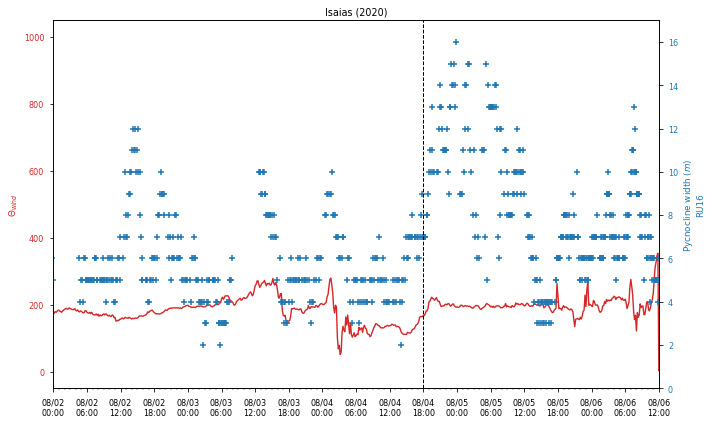

In [57]:
fig, ax1 = plt.subplots(figsize=(10,6))
plt.title('Isaias (2020)')
color = 'tab:red'
#ax1.set_xlabel('date in 2011')
ax1.set_ylabel(r'$\Theta_{wind}$', color=color)
ax1.plot(ndb_datenum, (winddir), color=color)
#ax1.plot(tck['datenum'],dtheta_tck_filt/dTtck /f, label='Tuckerton', color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim([-1,2.5])
#ax1.grid(color=color, linestyle='-.', linewidth=0.2)
ax1.grid(False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pycnocline width ($m$)\nRU16', color=color)  # we already handled the x-label with ax1
ax2.scatter(casttimes, high_depth - low_depth, s=45, color=color, marker='+', linewidth=1.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,17])
#ax2.grid(color=color, linestyle='-.', linewidth=0.2)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M"))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.grid(True)
plt.xlim([start+1.25, enddd-0.25])
plt.axvline(x = eyepassage, c='k', linestyle="--", linewidth=1)

fig.tight_layout() 
plt.savefig('Isaias_2020_wind.pdf', bbox_inches='tight')

In [58]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.gridspec as gridspec
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

roms_url = "http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/his/History_Best"

In [59]:
dr = xr.open_dataset(roms_url)

In [60]:
dr

<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 105, eta_rho: 106, eta_u: 106, eta_v: 105, ocean_time: 24, s_rho: 40, s_w: 41, time: 27732, time1: 27732, tracer: 2, xi_psi: 241, xi_rho: 242, xi_u: 241, xi_v: 242)
Coordinates:
  * s_rho           (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
  * s_w             (s_w) float64 -1.0 -0.975 -0.95 -0.925 ... -0.05 -0.025 0.0
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
  * ocean_time      (ocean_time) datetime64[ns] 2020-12-14T01:00:00 ... 2020-...
  * time            (time) datetime64[ns] 2017-11-02T01:00:00 ... 2020-12-31T...
    time_run        (time) datetime64[ns] ...
  * time1           (time1) datetime64[ns] 2017-11-02T01:00:00 ... 2020-12-31...
    time1_run       (time1) datetime64[ns] ...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    shuffle         int32 ...
    deflate         int32 ...
    deflate_level   int32 ...
    nHIS            int32 ...
    ndefHIS         int32 ...
    nRST            int32 ...
    ntsAVG          int32 ...
    nAVG            int32 ...
    ndefAVG         int32 ...
    Falpha          float64 ...
    Fbeta           float64 ...
    Fgamma          float64 ...
    nl_tnu2         (tracer) float64 ...
    nl_visc2        float64 ...
    LuvSponge       int32 ...
    LtracerSponge   (tracer) int32 ...
    Akt_bak         (tracer) float64 ...
    Akv_bak         float64 ...
    Akk_bak         float64 ...
    Akp_bak         float64 ...
    rdrg            float64 ...
    rdrg2           float64 ...
    Zob             float64 ...
    Zos             float64 ...
    gls_p           float64 ...
    gls_m           float64 ...
    gls_n           float64 ...
    gls_cmu0        float64 ...
    gls_c1          float64 ...
    gls_c2          float64 ...
    gls_c3m         float64 ...
    gls_c3p         float64 ...
    gls_sigk        float64 ...
    gls_sigp        float64 ...
    gls_Kmin        float64 ...
    gls_Pmin        float64 ...
    Charnok_alpha   float64 ...
    Zos_hsig_alpha  float64 ...
    sz_alpha        float64 ...
    CrgBan_cw       float64 ...
    Znudg           float64 ...
    M2nudg          float64 ...
    M3nudg          float64 ...
    Tnudg           (tracer) float64 ...
    FSobc_in        (boundary) float64 ...
    FSobc_out       (boundary) float64 ...
    M2obc_in        (boundary) float64 ...
    M2obc_out       (boundary) float64 ...
    Tobc_in         (boundary, tracer) float64 ...
    Tobc_out        (boundary, tracer) float64 ...
    M3obc_in        (boundary) float64 ...
    M3obc_out       (boundary) float64 ...
    rho0            float64 ...
    gamma2          float64 ...
    LuvSrc          int32 ...
    LwSrc           int32 ...
    LtracerSrc      (tracer) int32 ...
    LsshCLM         int32 ...
    Lm2CLM          int32 ...
    Lm3CLM          int32 ...
    LtracerCLM      (tracer) int32 ...
    LnudgeM2CLM     int32 ...
    LnudgeM3CLM     int32 ...
    LnudgeTCLM      (tracer) int32 ...
    spherical       int32 ...
    xl              float64 ...
    el              float64 ...
    Vtransform      int32 ...
    Vstretching     int32 ...
    theta_s         float64 ...
    theta_b         float64 ...
    Tcline          float64 ...
    hc              float64 ...
    grid            int32 ...
    Cs_r            (s_rho) float64 ...
    Cs_w            (s_w) float64 ...
    h               (eta_rho, x

In [61]:
beforE = mdates.date2num(datetime.datetime(2020,8,4,12))
durinE = mdates.date2num(datetime.datetime(2020,8,5,0))
afterE = mdates.date2num(datetime.datetime(2020,8,5,12))

In [62]:
romsdnum = mdates.date2num(dr.time)

In [63]:
dT = np.abs(romsdnum - beforE)
qbef = np.where(dT == np.nanmin(dT))[0][0]

dT = np.abs(romsdnum - afterE)
qaft = np.where(dT == np.nanmin(dT))[0][0]

dT = np.abs(romsdnum - durinE)
qdur = np.where(dT == np.nanmin(dT))[0][0]
mdates.num2date(romsdnum[qdur])

datetime.datetime(2020, 8, 5, 0, 0, tzinfo=datetime.timezone.utc)

In [64]:
dr.temp.shape
title_list = ["4 AUG 2020 12:00 UTC", "5 AUG 2020 00:00 UTC", "5 AUG 2020 12:00 UTC"]

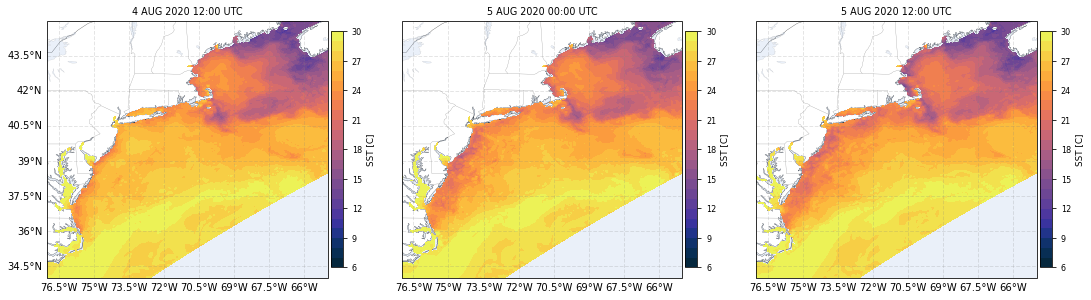

In [67]:
qs = [qbef, qdur, qaft]
fig, ax = plt.subplots(ncols=len(qs),nrows=1,figsize=(18,10), subplot_kw={'projection': ccrs.PlateCarree()})

for i in range(len(qs)):
    tmap = ax[i].contourf(dr.lon_rho, dr.lat_rho, dr.temp[qs[i],-1,:,:], cmap='cmo.thermal', levels=np.linspace(6,30,25))
                        #vmin=8, vmax=30, shading='flat')
    ax[i].set_title(title_list[i])
    ax[i].add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines',
                     '50m', edgecolor='gray', facecolor='none'))
    ax[i].add_feature(cartopy.feature.BORDERS, edgecolor='k', facecolor='none')
    ax[i].add_feature(cartopy.feature.OCEAN, edgecolor='k', facecolor='none')
    ax[i].add_feature(cartopy.feature.OCEAN, alpha=0.2)
    ax[i].add_feature(cartopy.feature.LAKES, alpha=0.2, edgecolor='k')
    ax[i].set_ylim([34,45])
    ax[i].set_xlim([-77, -65])
    plt.colorbar(tmap, fraction=0.04, label="SST [C]", pad=0.01, ax=ax[i])
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    if i ==0:
        gl.top_labels = False
        gl.right_labels = False
    else:
        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = False

plt.savefig("FIGS/map_ROMS_SST_Isaias.pdf", bbox_inches='tight')

In [139]:
b_lat, b_lon = 39.749672, -74.093013

dist = np.sqrt((b_lat - dr.lat_rho)**2 + (b_lon - dr.lon_rho)**2)
bb = np.where(dist == np.nanmin(dist))[1][0]

In [140]:
from geopy.distance import great_circle

In [141]:
dr.lat_rho[:,bb].shape

(106,)

In [142]:
barnegat = (b_lat, b_lon)
distest = [great_circle(barnegat, (dr.lat_rho[i,bb],dr.lon_rho[i,bb])).kilometers for i in range(dr.lat_rho[:,bb].shape[0])]
distestV = [great_circle(barnegat, (dr.lat_v[i,bb],dr.lon_v[i,bb])).kilometers for i in range(dr.lat_v[:,bb].shape[0])] 

In [143]:
distancemiles = -1*np.sign(np.gradient(distest))*distest
distancemileV = -1*np.sign(np.gradient(distestV))*distestV

In [144]:
depthtest = np.ones_like(dr.temp[qs[0],:,:,bb].values)*np.nan
lontest   = np.ones_like(dr.temp[qs[0],:,:,bb].values)*np.nan

depthV = np.ones_like(dr.v[qs[0],:,:,bb].values)*np.nan
lonV  = np.ones_like(dr.v[qs[0],:,:,bb].values)*np.nan

depthW = np.ones_like(dr.w[qs[0],:,:,bb].values)*np.nan
lonW  = np.ones_like(dr.w[qs[0],:,:,bb].values)*np.nan

In [145]:
lenslice = np.shape(dr.h[:,bb])[0]
lensliceV = dr.v[qs[0],:,:,bb].shape[1]

In [146]:
for i in range(lenslice):
    #depthtest[:,i] = dr.s_rho + dr.zeta[qs[0],i,bb] * (1 + dr.s_rho/dr.h[i,bb])
    #depthtest[:,i] = dr.zeta[qs[1],i,bb] + (dr.zeta[qs[1],i,bb] + dr.h[i,bb])*dr.s_rho
    depthtest[:,i] = dr.h[i,bb]*dr.s_rho
    depthW[:,i]    = dr.h[i,bb]*dr.s_w
    
for i in range(lensliceV):
    #depthtest[:,i] = dr.s_rho + dr.zeta[qs[0],i,bb] * (1 + dr.s_rho/dr.h[i,bb])
    #depthtest[:,i] = dr.zeta[qs[1],i,bb] + (dr.zeta[qs[1],i,bb] + dr.h[i,bb])*dr.s_rho
    depthV[:,i] = dr.h[i,bb]*dr.s_rho

In [147]:
for i in range(lenslice):
    lontest[:,i] = distancemiles[i] #dr.lon_rho[i,bb]
    lonW[:,i]    = distancemiles[i] #dr.lon_rho[i,bb]
    
for i in range(lensliceV):
    lonV[:,i] = distancemileV[i] #dr.lon_rho[i,bb]

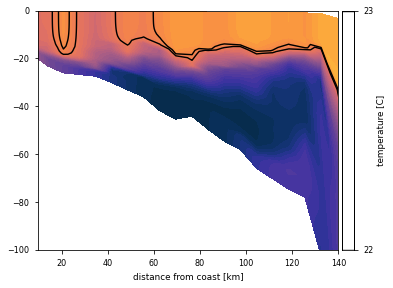

In [148]:
plt.contourf(lontest, depthtest, dr.temp[qs[1],:,:,bb], cmap=cmo.thermal, levels=np.linspace(6,30))
plt.contour(lontest, depthtest, dr.temp[qs[1],:,:,bb], colors='k', levels=np.array([22,23]))
plt.ylim([-100,0])
plt.xlim([10, 140])
plt.xlabel('distance from coast [km]')
plt.colorbar(pad=0.01, label="temperature [C]")

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


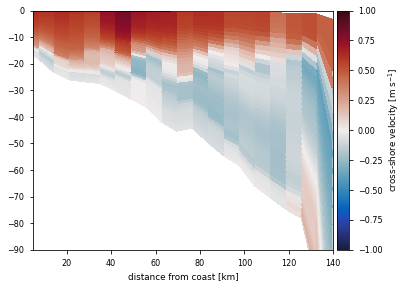

In [149]:
plt.pcolor(lontest, depthtest, dr.u[qs[1],:,:,bb], cmap=cmo.balance, vmin=-1, vmax=1)
plt.ylim([-90,0])
plt.xlim([5, 140])
plt.xlabel('distance from coast [km]')
plt.colorbar(pad=0.01, label="cross-shore velocity [m s$^{-1}$]")

In [132]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [151]:
dr.time

<xarray.DataArray 'time' (time: 27588)>
array(['2017-11-02T01:00:00.000000000', '2017-11-02T02:00:00.000000000',
       '2017-11-02T03:00:00.000000000', ..., '2020-12-25T10:00:00.000000000',
       '2020-12-25T11:00:00.000000000', '2020-12-25T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2017-11-02T01:00:00 ... 2020-12-25T12:00:00
    time_run  (time) datetime64[ns] 2017-11-01 2017-11-01 ... 2020-12-19
Attributes:
    long_name:            Forecast time for ForecastModelRunCollection
    standard_name:        time
    _CoordinateAxisType:  Time

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.p

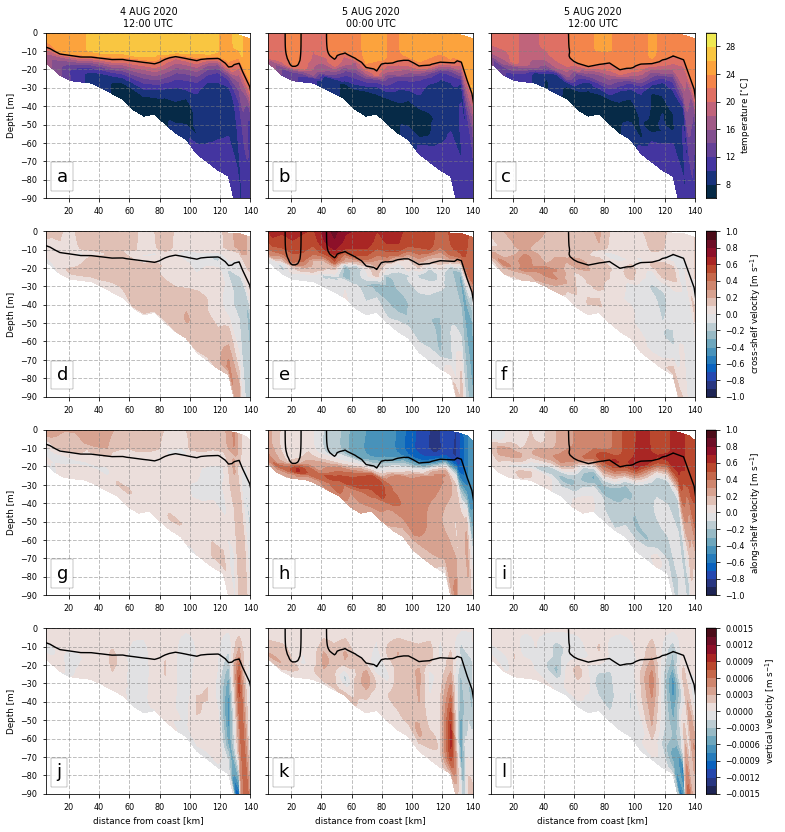

In [154]:
fig = plt.figure(figsize=(12, 14))

grid2 = ImageGrid(fig, 411,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.25,
                 share_all=True,
                 aspect=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
varT = np.asarray([dr.temp[q,:,:,bb] for q in qs])
levels = np.linspace(6,30,13)
titles = ['4 AUG 2020\n12:00 UTC', '5 AUG 2020\n00:00 UTC', '5 AUG 2020\n12:00 UTC']
plotnum = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

for i,ax in enumerate(grid2):
    im = ax.contourf(lontest, depthtest,varT[i],cmap='cmo.thermal', levels=levels)
    ln = ax.contour(lontest, depthtest, varT[i], colors='k', levels=np.array([0,22]))
    ax.annotate(s=f'{plotnum[i]}', fontsize=18, 
                xy=(.05, .1), xycoords='axes fraction', 
                bbox=dict(boxstyle="square", fc="w", alpha=0.9))
    ax.set_title(titles[i])
    #ax.xaxis.set_major_formatter(myFmt)
    #ax.set_xticklabels([])
    ax.grid(linewidth=1, linestyle="--", alpha=0.5, c='gray')
    ax.set_xlim([5, 140])
    ax.set_ylim([-90,0])
    ax.set_ylabel('Depth [m]')
    
# Colorbar
ax.cax.colorbar(im, ticks=levels[1::2])
cax = grid2.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text(r"temperature [$^{\circ}$C]")

grid3 = ImageGrid(fig, 412,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.25,
                 share_all=True,
                 aspect=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.15,
                 )


# Add data to image grid
var = np.asarray([dr.u[q,:,:,bb] for q in qs])
varmax = np.max(np.abs([np.nanmax(var), np.nanmin(var)]))
levels = np.linspace(-1,1,21)

for i,ax in enumerate(grid3):
    im = ax.contourf(lontest, depthtest,var[i],cmap='cmo.balance', levels=levels)
    ln = ax.contour(lontest, depthtest, varT[i], colors='k', levels=np.array([0,22]))
    ax.annotate(s=f'{plotnum[i+3]}', fontsize=18, xy=(.05, .1), 
                xycoords='axes fraction', bbox=dict(boxstyle="square", fc="w", alpha=0.9))
    #ax.set_xticklabels([])
    ax.grid(linewidth=1, linestyle="--", alpha=0.5, c='gray')
    ax.set_xlim([5, 140])
    ax.set_ylim([-90,0])
    ax.set_ylabel('Depth [m]')

# Colorbar
ax.cax.colorbar(im, ticks=levels[0::2])
cax = grid3.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text(r"cross-shelf velocity [m s$^{-1}$]")

grid4 = ImageGrid(fig, 413,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.25,
                 share_all=True,
                 aspect=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.15,
                 )


# Add data to image grid
var = np.asarray([dr.v[q,:,:,bb] for q in qs])
varmax = np.max(np.abs([np.nanmax(var), np.nanmin(var)]))
levels = np.linspace(-1,1,21)

for i,ax in enumerate(grid4):
    im = ax.contourf(lonV, depthV, var[i],cmap='cmo.balance', levels=levels)
    ln = ax.contour(lontest, depthtest, varT[i], colors='k', levels=np.array([0,22]))
    ax.annotate(s=f'{plotnum[i+6]}', fontsize=18, xy=(.05, .1), 
                xycoords='axes fraction', bbox=dict(boxstyle="square", fc="w", alpha=0.9))
    #ax.set_xticklabels([])
    ax.grid(linewidth=1, linestyle="--", alpha=0.5, c='gray')
    ax.set_xlim([5, 140])
    ax.set_ylim([-90,0])
    ax.set_ylabel('Depth [m]')

# Colorbar
ax.cax.colorbar(im, ticks=levels[0::2])
cax = grid4.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text(r"along-shelf velocity [m s$^{-1}$]")

grid  = ImageGrid(fig, 414,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.25,
                 share_all=True,
                 aspect=False,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.15,
                 )


# Add data to image grid
var = np.asarray([dr.w[q,:,:,bb] for q in qs])
varmax = np.max(np.abs([np.nanmax(var), np.nanmin(var)]))
levels = np.linspace(-0.0015,0.0015,21)

for i,ax in enumerate(grid):
    im = ax.contourf(lonW, depthW, var[i],cmap='cmo.balance', levels=levels)
    ln = ax.contour(lontest, depthtest, varT[i], colors='k', levels=np.array([0,22]))
    ax.annotate(s=f'{plotnum[i+9]}', fontsize=18, xy=(.05, .1), 
                xycoords='axes fraction', bbox=dict(boxstyle="square", fc="w", alpha=0.9))
    ax.grid(linewidth=1, linestyle="--", alpha=0.5, c='gray')
    ax.set_xlim([5, 140])
    ax.set_ylim([-90,0])
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('distance from coast [km]')

# Colorbar
ax.cax.colorbar(im, ticks=levels[0::2])
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text(r"vertical velocity [m s$^{-1}$]")

plt.savefig("FIGS/ROMS_slice_Isaias.pdf", bbox_inches='tight')
plt.show()

/Users/cew145/miniconda3/envs/pangeo/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


(-77.0, -65.0)

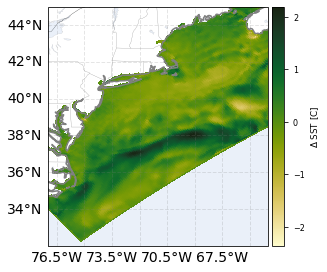

In [79]:
fig = plt.figure()
ax  = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='gray', linewidth=1.5)

tmap = plt.pcolor(dr.lon_rho, dr.lat_rho, dr.u_eastward[qaft,-1,:,:], cmap=cmo.speed)
plt.colorbar(tmap, label="$\Delta$ SST [C]", pad=0.01)

ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines',
                     '50m', edgecolor='gray', facecolor='none'))
ax.add_feature(cartopy.feature.BORDERS, edgecolor='k', facecolor='none')
ax.add_feature(cartopy.feature.OCEAN, alpha=0.2)
ax.add_feature(cartopy.feature.LAKES, alpha=0.2, edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')


gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
plt.ylim([32,45])
plt.xlim([-77, -65])